![](../resources/Custom_croptype_map.png)

### Content

- [Introduction](###-Introduction)
- [How to run this notebook?](###-How-to-run-this-notebook?)
- [Before you start](###-Before-you-start)
- [1. Gather and prepare your training data](###-1.-Gather-and-prepare-your-training-data)
- [2. Train custom classification model](###-2.-Train-custom-classification-model)
- [3. Deploy your custom model](###-3.-Deploy-your-custom-model)
- [4. Generate your custom crop type map](###-4.-Generate-your-custom-crop-type-map)

### Introduction

This notebook guides you through the process of training a custom crop type classification model for your area, season and crop types of interest.

For training the model, you can use a combination of:
- publicly available reference data harmonized by the WorldCereal consortium;
- your own private reference data.

<div class="alert alert-block alert-warning">
In case you would like to use private reference data to train your model, make sure to first complete the workflow as outlined in our separate notebook <b>worldcereal_private_extractions.ipynb</b>.
</div>

After model training, we deploy your custom model to the cloud, from where it can be accessed by OpenEO, allowing you to apply your model on your area and season of interest and generate your custom crop type map.

### How to run this notebook?

#### Option 1: Run on Terrascope

You can use a preconfigured environment on [**Terrascope**](https://terrascope.be/en) to run the workflows in a Jupyter notebook environment. Just register as a new user on Terrascope or use one of the supported EGI eduGAIN login methods to get started.

Once you have a Terrascope account, you can run this notebook by clicking the button shown below.

<div class="alert alert-block alert-warning">When you click the button, you will be prompted with "Server Options".<br>
Make sure to select the "Worldcereal" image here. Did you choose "Terrascope" by accident?<br>
Then go to File > Hub Control Panel > Stop my server, and click the link below once again.</div>


<a href="https://notebooks.terrascope.be/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2FWorldCereal%2Fworldcereal-classification&urlpath=lab%2Ftree%2Fworldcereal-classification%2Fnotebooks%2Fworldcereal_custom_croptype.ipynb&branch=main"><img src="https://img.shields.io/badge/Generate%20custom%20crop%20type%20map-Terrascope-brightgreen" alt="Generate custom crop type map" valign="middle"></a>


<div class="alert alert-block alert-warning">
<b>WARNING:</b> <br>
Every time you click the above link, the latest version of the notebook will be fetched, potentially leading to conflicts with changes you have made yourself.<br>
To avoid such code conflicts, we recommend you to make a copy of the notebook and make changes only in your copied version.
</div>


#### Option 2: Install Locally

If you prefer to install the package locally, you can create the WorldCereal environment using **Conda** or **pip**.

First clone the repository:
```bash
git clone https://github.com/WorldCereal/worldcereal-classification.git
cd worldcereal-classification
```
Next, install the package locally:
- for Conda: `conda env create -f environment.yml`
- for Pip: `pip install .[train,notebooks]`

### Before you start

In order to run WorldCereal crop mapping jobs from this notebook, you need to create an account on the [Copernicus Data Space Ecosystem](https://dataspace.copernicus.eu/).<br>
This is free of charge and will grant you a number of free openEO processing credits to continue this demo.


#### CDSE authentication

Run the cell below to make sure you are connected to your CDSE account before starting the application.

In [1]:
from openeo_gfmap.backend import cdse_connection
cdse_connection()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

### Ensure proper access to functionality

Execute the next block of code to ensure this notebook has access to all functionalities needed in this exercise.

In [2]:
# add parent dirctory to sys.path
import sys
sys.path.append('..')

### 1. Choose finetuned Presto model for your experiments

In the cell below, you have the choice to either use our default presto model that was trained for global requirements, or a more specialised model that was finetuned for Kenya.

Simply set `model_bundle` parameter to either "kenya" or "default".

We recommend to use the kenya model.

Execute the next cell before continuing!

In [ ]:
from pathlib import Path
import urllib.request
from worldcereal.train.backbone import checkpoint_fingerprint
from worldcereal.openeo.parameters import DEFAULT_SEASONAL_MODEL_URL

model_bundle = "kenya"
# model_bundle = "default"

if model_bundle == "kenya":
    presto_model_path = "https://artifactory.vgt.vito.be/artifactory/auxdata-public/worldcereal/demo/kenya/presto-prometheo-kenya-finetuned-noaugment-month-augment=False-balance=True-timeexplicit=True-masking=enabled-run=202602101037_encoder.pt"
    seasonal_model_zip_path = "https://artifactory.vgt.vito.be/artifactory/auxdata-public/worldcereal/demo/kenya/presto-prometheo-kenya-finetuned-noaugment-month-augment=False-balance=True-timeexplicit=True-masking=enabled-run=202602101037.zip"
    # Download the kenya presto model to your machine to run training and local inference
    local_pt = Path("./local_inference/kenya_local_presto_encoder.pt")
    local_pt.parent.mkdir(parents=True, exist_ok=True)
    if not local_pt.exists():
        urllib.request.urlretrieve(presto_model_path, local_pt)
    # We'll need to explicitly check model's fingerprint here
    presto_fp = checkpoint_fingerprint(local_pt)
    
    presto_model_package = {"presto_remote_path": presto_model_path,
                            "presto_local_path": str(local_pt),
                            "presto_fingerprint": presto_fp,
                            "seasonal_model_path": seasonal_model_zip_path}
    
elif model_bundle == "default":
    seasonal_model_zip_path = DEFAULT_SEASONAL_MODEL_URL
    presto_model_package = None
    
else:
    raise ValueError(f"Unknown model bundle: {model_bundle}. Supported options are 'kenya' and 'default'.")

### 2. Train your model

Launch the application in the next cell to train your crop type model for Kenya!

Make sure to choose the option "**Full workflow**" in the welcome screen of the application.<br>

Then complete steps 1 --> 6 (stop before deploying your model in step 7).<br>

Brief outline of steps:
1. Retrieve existing reference data (make sure to select Kenya as AOI!)
2. Inspect the reference data
3. Choose your season of interest and align your reference data to that season
4. Compute Presto embeddings on your reference data
5. Select data and compile the list of classes you want to include in your model
6. Train your model

Once finalized, **continue with the next cell in this notebook**.

In [ ]:
from notebook_utils.training_app import WorldCerealTrainingApp

app = WorldCerealTrainingApp().run(presto_model_package=presto_model_package)

### 3. Local Inference

As an alternative to the model deployment and inference steps as exposed in the application above (steps 7 -> 9), we offer here the possibility to quickly run your newly trained model on some prepared patches across Kenya. For these patches, we have already fetched the required pre-processed time series inputs from CDSE using openEO workflows. For more information on this procedure, you can consult the [worldcereal_preprocessed_inputs notebook](https://github.com/WorldCereal/worldcereal-classification/blob/main/notebooks/worldcereal_preprocessed_inputs.ipynb).

The next cells load one of these prepared patches, show a random NDVI slice for context, and call `run_seasonal_inference()` with the seasonal backbone plus your custom croptype head to produce a croptype raster for the chosen season.

This step is meant for fast QA and tuning of inference knobs and post-processing; it does not replace the full openEO production run. The output is written as a GeoTIFF under `./local_inference/` with a filename that includes the patch and head package, so you can inspect it in your GIS tools or compare with reference data.


**Download and visualize one patch**

Selected patch: patch01
-------------------------------------
Band statistics (NetCDF):
+---------------+------------+-----------+-----------+-----------+---------+
|               |   %_nodata |       min |       max |      mean |     std |
|---------------+------------+-----------+-----------+-----------+---------|
| S2-L2A-B02    |       2.81 |    0.0102 |    0.528  |    0.0687 |  0.0221 |
| S2-L2A-B03    |       2.81 |    0.0241 |    0.4992 |    0.0932 |  0.0223 |
| S2-L2A-B04    |       2.81 |    0.0139 |    0.4834 |    0.1032 |  0.0362 |
| S2-L2A-B05    |       2.81 |    0.0339 |    0.395  |    0.1481 |  0.0298 |
| S2-L2A-B06    |       2.81 |    0.0173 |    0.45   |    0.2234 |  0.0353 |
| S2-L2A-B07    |       2.81 |    0.0279 |    0.4652 |    0.2499 |  0.0414 |
| S2-L2A-B08    |       2.81 |    0.0196 |    0.5192 |    0.2582 |  0.0427 |
| S2-L2A-B8A    |       2.81 |    0.0169 |    0.5    |    0.2788 |  0.0426 |
| S2-L2A-B11    |       2.81 |    0.0397 |    0.5576 |    0.2881 

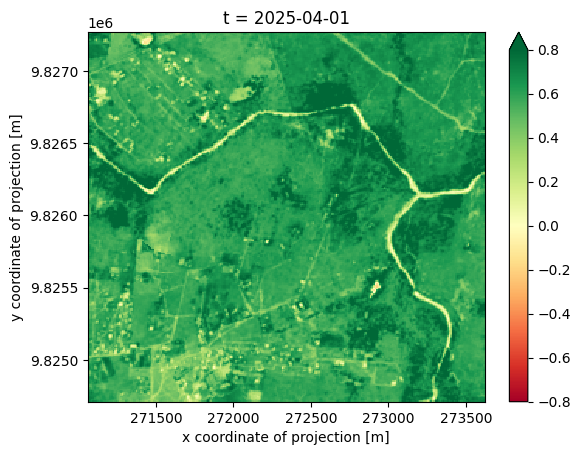

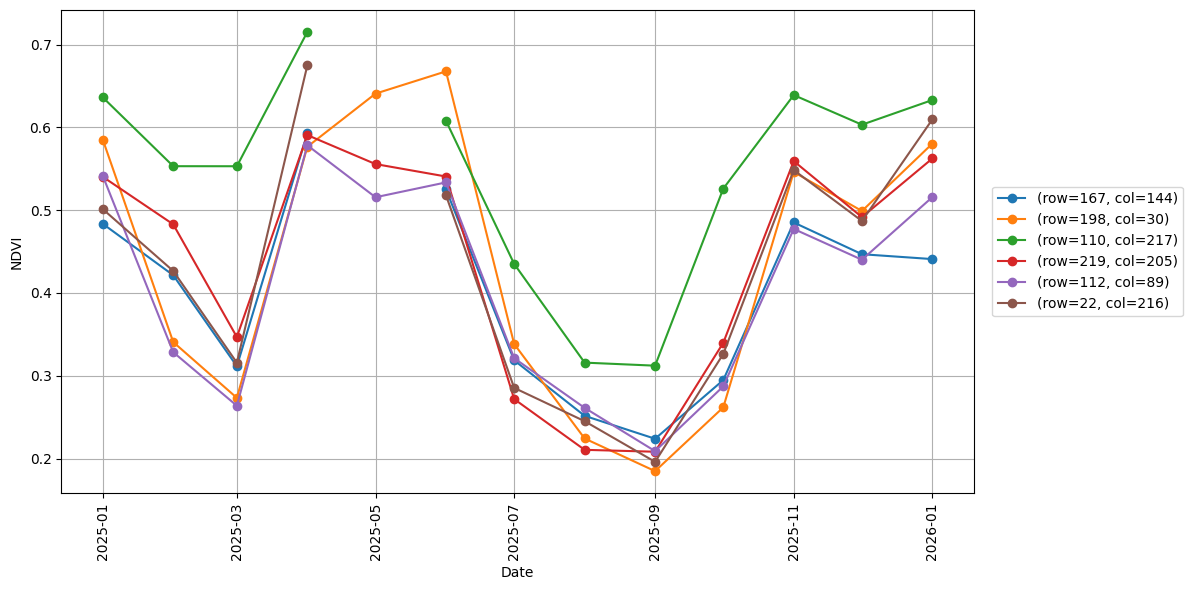

In [17]:
import random
import numpy as np
from pathlib import Path
import urllib.request

from pyproj import CRS
import xarray as xr

from notebook_utils.preprocessed_inputs import get_band_statistics_netcdf, visualize_timeseries_netcdf

# randomly select an option from the following list:
options = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
selected = random.choice(options)

patch_id = f"patch{selected}"
print(f"Selected patch: {patch_id}")

# Download the demo patch from artifactory if the requested patch is missing locally.
local_file_path = Path(f"./local_inference/input_patches/preprocessed-inputs_{patch_id}.nc")
if not local_file_path.exists():
    local_file_path.parent.mkdir(parents=True, exist_ok=True)
    if not local_file_path.exists():
        print(f"Downloading demo preprocessed inputs to {local_file_path}...")
        remote_url = (
            f"https://artifactory.vgt.vito.be/artifactory/auxdata-public/worldcereal/demo/kenya/preprocessed-inputs_{patch_id}.nc"
        )
        urllib.request.urlretrieve(remote_url, local_file_path)

ds = xr.open_dataset(local_file_path, engine="netcdf4")
epsg = CRS.from_wkt(ds.crs.attrs["spatial_ref"]).to_epsg()

# Visualize a random timestamp from the patch
ndvi = (ds["S2-L2A-B08"] - ds["S2-L2A-B04"]) / (ds["S2-L2A-B08"] + ds["S2-L2A-B04"])
timestamp_ind = np.random.randint(0, ndvi.shape[0])
ndvi.isel(t=timestamp_ind).plot(cmap="RdYlGn", vmin=-0.8, vmax=0.8)

# Show band statistics
stats = get_band_statistics_netcdf(ds)

# Visualize random time series
visualize_timeseries_netcdf(ds, band="NDVI", npixels=6, random_seed=42)

**Set processing parameters**

Configure the inference and post-processing parameters:

- `mask_cropland`: Apply cropland masking during croptype predictions
- `enable_cropland_head`: Also export cropland probability rasters for quality assurance
- `export_class_probs`: Emit per-class probability layers for each crop type
- `croptype_postprocess_enabled`: Apply spatial post-processing to croptype classifications
- `croptype_postprocess_method`: Post-processing algorithm (e.g., "majority_vote")
- `croptype_postprocess_kernel`: Kernel size for post-processing filter
- `cropland_postprocess_enabled`: Apply spatial post-processing to cropland mask
- `cropland_postprocess_method`: Post-processing algorithm for cropland
- `cropland_postprocess_kernel`: Kernel size for cropland post-processing

In [ ]:
mask_cropland = True  # cropland masking using default cropland model
enable_cropland_head = True  # also export cropland rasters for QA
enable_croptype_head = True  # whether to run the croptype head at all (if False, only cropland predictions will be made)
export_class_probs = True  # export per-class probabilities in the crop type product

croptype_postprocess_enabled = True
croptype_postprocess_method = "majority_vote"
croptype_postprocess_kernel = 2

cropland_postprocess_enabled = True
cropland_postprocess_method = "majority_vote"
cropland_postprocess_kernel = 2

**Specify year and season**

For your information, we first display for which season_id and growing season period you have trained your model:

In [9]:
season_id = app.season_id
print(f"Model trained for season id: {season_id}")
season_window = app.season_window
print(f"Model trained for season: {season_window.start_date} - {season_window.end_date}")

Model trained for season id: LongRains
Model trained for season: 2021-03-01 - 2021-08-31


In the next cell, you can now manually set a start and end date + season id.

In [ ]:
season_id = "xxx"                 # e.g. LongRains 
season_start_date = "YYYY-mm-dd"  # e.g. 2021-03-01
season_end_date = "YYYY-mm-dd"    # e.g. 2021-08-31

**Run local inference**

In [ ]:
import json

from notebook_utils.local_inference import (
    run_seasonal_inference,
    build_postprocess_spec,
    classification_to_geotiff,
)

season_windows = {
    season_id: (str(season_start_date), str(season_end_date))
}

croptype_postprocess = build_postprocess_spec(
    enabled=croptype_postprocess_enabled,
    method=croptype_postprocess_method,
    kernel_size=croptype_postprocess_kernel,
)
cropland_postprocess = build_postprocess_spec(
    enabled=cropland_postprocess_enabled,
    method=cropland_postprocess_method,
    kernel_size=cropland_postprocess_kernel,
)

classification_result = run_seasonal_inference(
    ds,  # or local_file_path
    seasonal_model_zip=seasonal_model_zip_path,
    landcover_head_zip=seasonal_model_zip_path,
    croptype_head_zip=app.head_package_path,  # the crop type model you trained in the app
    season_ids=[season_id],
    season_windows=season_windows,
    enforce_cropland_gate=mask_cropland,
    export_class_probabilities=export_class_probs,
    enable_cropland_head=enable_cropland_head,
    enabel_croptype_head=enable_croptype_head,
    croptype_postprocess=croptype_postprocess,
    cropland_postprocess=cropland_postprocess,
    as_dataset=False,  # DataArray for GeoTIFF
)

# Specify output directory and name for the classification result
output_dir = Path("./local_inference")
output_dir.mkdir(parents=True, exist_ok=True)
head_tag = Path(head_package_path).stem
classification_result_path = output_dir / f"croptype_{season_id}_{patch_id}_{head_tag}.tif"

# get model class names from the model config file
head_output_dir = app.head_output_path
head_config_path = head_output_dir / "config.json"
if not head_config_path.exists():
    raise FileNotFoundError(
        f"Torch head config not found at {head_config_path}. Check the training logs above."
    )
with head_config_path.open() as fp:
    head_config = json.load(fp)
class_map = {i: name for i, name in enumerate(head_config["classes_list"])}

# Finally, save to geotiff
classification_to_geotiff(classification_result, epsg, classification_result_path, class_map)

16:37:47 | INFO | Downloading seasonal model artifact from https://artifactory.vgt.vito.be/artifactory/auxdata-public/worldcereal/demo/kenya/presto-prometheo-kenya-finetuned-noaugment-month-augment=False-balance=True-timeexplicit=True-masking=enabled-run=202602101037.zip
16:37:48 | INFO | Replacing landcover head: linear/10 -> linear/10
16:37:48 | WARNING | Custom landcover head state dict mismatch. Missing=['linear.weight', 'linear.bias'], unexpected=['backbone.encoder.pos_embed', 'backbone.encoder.eo_patch_embed.S1.weight', 'backbone.encoder.eo_patch_embed.S1.bias', 'backbone.encoder.eo_patch_embed.S2_RGB.weight', 'backbone.encoder.eo_patch_embed.S2_RGB.bias', 'backbone.encoder.eo_patch_embed.S2_Red_Edge.weight', 'backbone.encoder.eo_patch_embed.S2_Red_Edge.bias', 'backbone.encoder.eo_patch_embed.S2_NIR_10m.weight', 'backbone.encoder.eo_patch_embed.S2_NIR_10m.bias', 'backbone.encoder.eo_patch_embed.S2_NIR_20m.weight', 'backbone.encoder.eo_patch_embed.S2_NIR_20m.bias', 'backbone.encod

ValueError: Custom croptype head backbone fingerprint mismatch: 6159f441b29f76270b8e82ddbd82ac2f2bb2c30d62e5bd5acb36d8f1733716a8 != dec8e85a436012ef0593e71520416b7936b8b8ec4242d26eecc895b6e9042b1b

The following cell helps you to quickly visualize the result.

For more detailed inspection, we advise to load the product in QGIS.

In [ ]:
from notebook_utils.visualization import visualize_products

path_croptype = Path("...")
path_cropland = Path("...")
paths = {"croptype": path_croptype}
if enable_cropland_head:
    paths["cropland"] = path_cropland

lut_croptype = {v: k for k, v in sorted(class_map.items(), key=lambda kv: kv[0])}
luts = {'croptype': lut_croptype}

visualize_products(paths, luts=luts)

Congratulations, you have reached the end of this demo!